# DDPG

DDPG implements a variant of Q learning by optimizing both action value and policy networks.
It is designed to support continuous action policies.

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
DEVICE

'cuda'

In [3]:
class QModel(torch.nn.Module):
    def __init__(self, state_size, action_size, hidden):
        super().__init__()
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(state_size + action_size, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, 1)
        )

    def forward(self, state, action):
        return self.nn(torch.concat([state, action], dim=-1)).squeeze(dim=-1)


QModel(2, 2, 4).forward(torch.ones(2), torch.zeros(2))

tensor(0.3157, grad_fn=<SqueezeBackward1>)

In [4]:
class PolicyModel(torch.nn.Module):
    def __init__(self, state_size, action_size, hidden, action_scaling):
        super().__init__()
        self.action_scaling = action_scaling
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(state_size, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, action_size),
            torch.nn.Tanh()
        )

    def forward(self, state):
        return self.nn(state) * self.action_scaling

    def act(self, state, policy_std=1e-6):
        action = torch.clip(
            torch.distributions.Normal(self.forward(state), policy_std).sample(),
            -self.action_scaling,
            self.action_scaling,
        )
        return action.detach().cpu().numpy()


PolicyModel(2, 2, 4, 2).act(torch.ones(2), 1)

array([ 2.       , -1.7447393], dtype=float32)

In [5]:
class ReplayBuffer:
    def __init__(self, o, a, size):
        self.buf = []
        self.size = size

    def add(self, state, action, reward, next_state, done):
        self.buf.append((state, action, reward, next_state, done))
        return self

    def crop_buffer(self):
        if len(self.buf) > self.size:
            self.buf = self.buf[-self.size:]

    def gen_batch(self, batch_size):
        np.random.shuffle(self.buf)
        b = self.buf[:batch_size]
        states = torch.tensor([b[y][0] for y in range(len(b))], dtype=torch.float32).to(DEVICE)
        actions = torch.tensor([b[y][1] for y in range(len(b))], dtype=torch.float32).to(DEVICE)
        rewards = torch.tensor([b[y][2] for y in range(len(b))], dtype=torch.float32).to(DEVICE)
        next_states = torch.tensor([b[y][3] for y in range(len(b))], dtype=torch.float32).to(DEVICE)
        dones = torch.tensor([b[y][4] for y in range(len(b))], dtype=torch.float32).to(DEVICE)
        return states, actions, rewards, next_states, dones


ReplayBuffer(0, 0, 3).add(0, 0, 0, 0, 0).add(1, torch.tensor(0), 1, 1, 1).add(2, torch.tensor(0), 2, 2, 2).gen_batch(2)

(tensor([0., 2.], device='cuda:0'),
 tensor([0., 0.], device='cuda:0'),
 tensor([0., 2.], device='cuda:0'),
 tensor([0., 2.], device='cuda:0'),
 tensor([0., 2.], device='cuda:0'))

# Training

In [6]:
import copy
from stable_baselines3.common.utils import polyak_update
import gym

def test_ddpg(env_name, pmodel, render=True):
    with gym.make(env_name) as env:
        total_rewards = []
        for j in range(5):
            total_reward = 0
            state = env.reset()
            done = False
            while not done:
                action = pmodel.act(torch.as_tensor(state, dtype=torch.float32, device=DEVICE))
                state, reward, done, _ = env.step(action)
                total_reward += reward
                if render:
                    env.render()
            total_rewards.append(total_reward)
        return np.mean(total_rewards), env


def ddpg(env_name,
         max_episodes,
         max_steps,
         hidden_size=128,
         policy_std=0.1,
         train_every_step=50,
         batch_size=100,
         target_update_rate=0.01,
         gamma=0.9,
         replay_buffer_size=100000,
         early_stopping_reward=1e9,
         act_after_steps=10000,
         train_after_steps=1000):
    with gym.make(env_name) as env:
        assert min(env.action_space.low) == max(env.action_space.low)
        assert min(env.action_space.high) == max(env.action_space.high)
        assert np.all(np.abs(env.action_space.low) == np.abs(env.action_space.high))

        pmodel = PolicyModel(env.observation_space.shape[0], env.action_space.shape[0], hidden_size, env.action_space.high[0]).to(DEVICE)
        qmodel = QModel(env.observation_space.shape[0], env.action_space.shape[0], hidden_size).to(DEVICE)
        print(pmodel)
        optim_p = torch.optim.Adam(pmodel.parameters())
        optim_q = torch.optim.Adam(qmodel.parameters())

        target_pmodel = copy.deepcopy(pmodel)
        target_qmodel = copy.deepcopy(qmodel)

        for p in target_qmodel.parameters():
            p.requires_grad = False
        for p in target_pmodel.parameters():
            p.requires_grad = False

        total_rewards = []

        buffer = ReplayBuffer(env.observation_space.shape[0], env.action_space.shape[0], replay_buffer_size)
        global_step = 0
        progress = tqdm(range(max_episodes), total=max_episodes)
        for _ in progress:
            state = env.reset()
            total_reward = 0
            for step in range(max_steps):

                if global_step > act_after_steps:
                    action = pmodel.act(torch.as_tensor(state, dtype=torch.float32, device=DEVICE), policy_std)
                else:
                    action = env.action_space.sample()

                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                buffer.add(state, action, reward, next_state, done)
                global_step += 1

                state = next_state

                if global_step % train_every_step == 0 and global_step > train_after_steps:
                    for _ in range(train_every_step):
                        states, actions, rewards, next_states, dones = buffer.gen_batch(batch_size)

                        # Q update
                        optim_q.zero_grad()
                        q = qmodel.forward(states, actions)
                        target = rewards
                        with torch.no_grad():
                            next_state_value = target_qmodel.forward(next_states.to(DEVICE), target_pmodel.forward(next_states.to(DEVICE)))
                            target += (1 - dones) * gamma * next_state_value

                        q_loss = ((target - q) ** 2).mean()
                        q_loss.backward()
                        optim_q.step()

                        # P update
                        q_req_grad = [p.requires_grad for p in qmodel.parameters()]
                        for p in qmodel.parameters():
                            p.requires_grad = False

                        optim_p.zero_grad()
                        actions = pmodel.forward(states.to(DEVICE))
                        p_loss = -qmodel.forward(states.to(DEVICE), actions).mean()
                        p_loss.backward()
                        optim_p.step()

                        for rg, p in zip(q_req_grad, qmodel.parameters()):
                            p.requires_grad = rg

                        # update target policies
                        polyak_update(qmodel.parameters(), target_qmodel.parameters(), target_update_rate)
                        polyak_update(pmodel.parameters(), target_pmodel.parameters(), target_update_rate)


                if done:
                    break

            total_rewards.append(total_reward)
            buffer.crop_buffer()

            test_reward = test_ddpg(env_name, pmodel, render=False)[0]
            if test_reward > early_stopping_reward:
                print("Early stopping!")
                break
            progress.set_description(f'Test reward:{test_reward:06.2f}')

        return target_pmodel, target_qmodel

# Pendulum-v1

In [7]:
pmodel, qmodel = ddpg(
    'Pendulum-v1',
     max_episodes=30,
     max_steps=500,
     hidden_size=256,
     policy_std=0.1,
     train_every_step=50,
     batch_size=100,
     target_update_rate=0.005,
     gamma=0.99,
     replay_buffer_size=100000,
     early_stopping_reward=-200
)

PolicyModel(
  (nn): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Tanh()
  )
)


  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_27247/3515204342.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  states = torch.tensor([b[y][0] for y in range(len(b))], dtype=torch.float32).to(DEVICE)


Early stopping!


In [8]:
env = test_ddpg('Pendulum-v1', pmodel, True)[1]

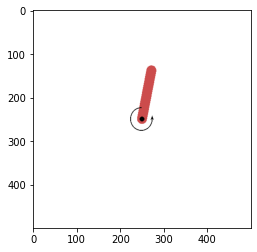

In [9]:
plt.imshow(env.render(mode='rgb_array'))

# HalfCheetah-v2

In [9]:
pmodel, qmodel = ddpg(
    'HalfCheetah-v2',
     max_episodes=50,
     max_steps=4000,
     hidden_size=1024,
     policy_std=0.1,
     train_every_step=50,
     batch_size=100,
     target_update_rate=0.005,
     gamma=0.99,
     replay_buffer_size=1e6,
     early_stopping_reward=1e9
)

running build_ext
PolicyModel(
  (nn): Sequential(
    (0): Linear(in_features=17, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=6, bias=True)
    (5): Tanh()
  )
)


  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_29729/3515204342.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  states = torch.tensor([b[y][0] for y in range(len(b))], dtype=torch.float32).to(DEVICE)


In [ ]:
env = test_ddpg('HalfCheetah-v2', pmodel, True)[1]

In [ ]:
plt.imshow(env.render(mode='rgb_array'))